In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [4]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/Apple.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [12]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [13]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4648.254, Time=3.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4642.260, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4641.807, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4641.516, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4641.954, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4639.630, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4641.517, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4643.512, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4640.444, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=4640.674, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4639.922, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=4642.402, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=4639.589, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=4641.515, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1

In [14]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([143.61203973, 142.55931095, 147.94098368, 144.68443572,
       139.90291285, 135.8199172 , 133.40948216, 131.49097325,
       134.99348525, 132.77981772, 130.67437392, 129.68068906,
       129.30682029, 128.76569861, 128.24425791, 129.17891458,
       126.9750954 , 126.09946002, 128.57876373, 131.64839354,
       129.53310237, 131.74676991, 132.48465909, 133.13400452,
       135.46572941, 136.76442224, 134.44252997, 136.18395237,
       141.39837219, 141.24095288, 140.52272992, 142.31334789,
       145.24522362, 143.59235875, 142.40189065, 144.63524015,
       149.13143702, 155.23133271, 151.02044611, 153.11604154,
       152.47654349, 152.23058043, 149.28885633, 152.16170389,
       151.67962514, 153.38168558, 154.19828491, 150.92205498,
       149.24950913, 147.9213027 , 148.30500409, 145.20587544,
       147.15389894, 147.06535617, 145.24522362, 144.73363128,
       149.06257523, 154.16877032, 151.93542181, 151.38446652,
       152.43718054, 148.89532134, 151.05979331, 151.31

In [15]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([143.61203973, 142.55931095, 147.94098368, 144.68443572,
       139.90291285, 135.8199172 , 133.40948216, 131.49097325,
       134.99348525, 132.77981772, 130.67437392, 129.68068906,
       129.30682029, 128.76569861, 128.24425791, 129.17891458,
       126.9750954 , 126.09946002, 128.57876373, 131.64839354,
       129.53310237, 131.74676991, 132.48465909, 133.13400452,
       135.46572941, 136.76442224, 134.44252997, 136.18395237,
       141.39837219, 141.24095288, 140.52272992, 142.31334789,
       145.24522362, 143.59235875, 142.40189065, 144.63524015,
       149.13143702, 155.23133271, 151.02044611, 153.11604154,
       152.47654349, 152.23058043, 149.28885633, 152.16170389,
       151.67962514, 153.38168558, 154.19828491, 150.92205498,
       149.24950913, 147.9213027 , 148.30500409, 145.20587544,
       147.15389894, 147.06535617, 145.24522362, 144.73363128,
       149.06257523, 154.16877032, 151.93542181, 151.38446652,
       152.43718054, 148.89532134, 151.05979331, 151.31

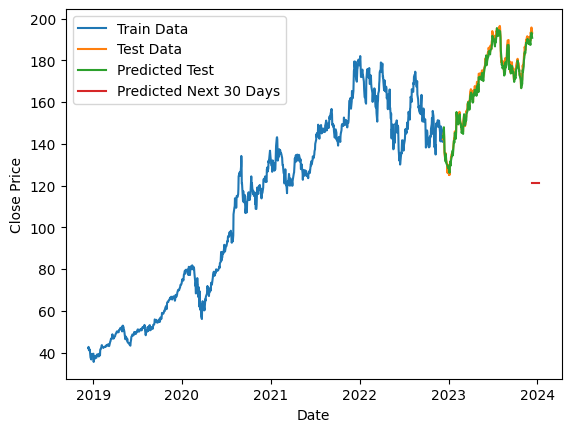

In [16]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [17]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 1.466
Testing RMSE: 1.641
Testing MAPE: 0.869


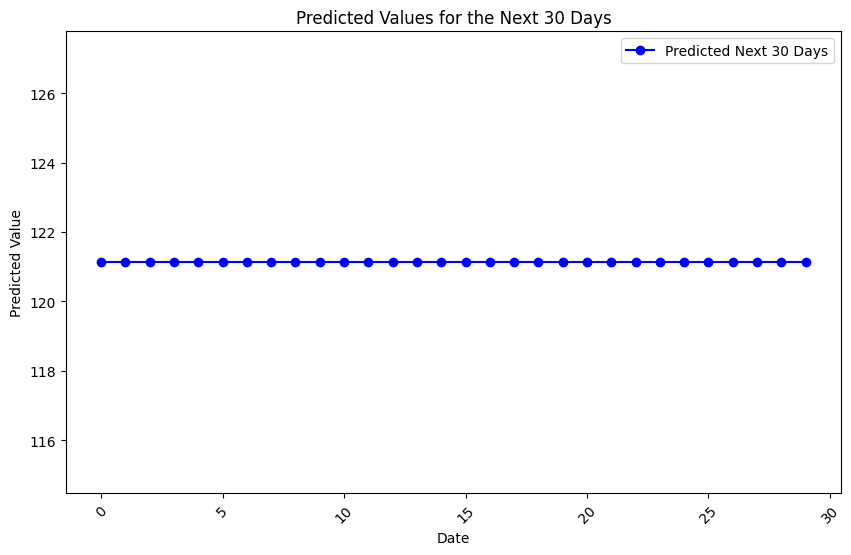

In [18]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


